# Computer vision part 1

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/05-computer-vision-1/seminar.ipynb)


- тонкости препроцессинга (читать, ресайзить, вот это вот все)
- CAM (class activation map) из предобученной сетки

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json

from tqdm.auto import tqdm

with open("imagenet_1k.json") as fin:
    clsidx = json.load(fin)

# Готовые сетки

`torchvision.models`

Возьмите любую картинку и попробуйте прогнать ее через сеть.

Например из картиночной выдачи
![из картиночной выдачи](https://sobakibalabaki.com/wp-content/uploads/2017/06/dog-and-horsejpg.jpg)

In [2]:
! wget https://sobakibalabaki.com/wp-content/uploads/2017/06/dog-and-horsejpg.jpg -O doge-and-horsy.jpg

--2021-02-16 20:18:51--  https://sobakibalabaki.com/wp-content/uploads/2017/06/dog-and-horsejpg.jpg
Resolving sobakibalabaki.com (sobakibalabaki.com)... 2606:4700:3030::ac43:ad57, 2606:4700:3033::6815:5019, 172.67.173.87, ...
Connecting to sobakibalabaki.com (sobakibalabaki.com)|2606:4700:3030::ac43:ad57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121011 (118K) [image/jpeg]
Saving to: ‘doge-and-horsy.jpg’

doge-and-horsy.jpg  100%[===================>] 118,17K  --.-KB/s    in 0,02s   

2021-02-16 20:18:51 (5,92 MB/s) - ‘doge-and-horsy.jpg’ saved [121011/121011]



# Предобработка картинок

Загрузите картинку и предобработайте ее для подачи в сеть

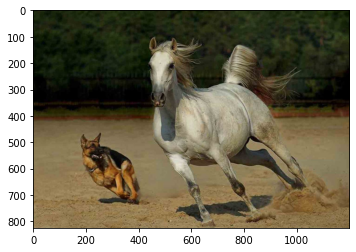

In [2]:
# PIL (Pillow)

def load(path):
    # RBG  -> 
    # RGBA -> 
    # Gray -> 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img = load("./doge-and-horsy.jpg")

plt.imshow(img)

In [3]:
cv2.imread?

In [4]:
net = torchvision.models.resnet50(pretrained=True)
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Inference

Разберитесь с ошибками и получите предикт :)

Проверьте правильность по `clsidx`.

In [5]:
def load(path):
    # RBG  -> 
    # RGBA -> 
    # Gray -> 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 210))  
    img = img.astype(np.float32) / 255.0 # img \in [0, 1]
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 1, 3)
    std =  np.array([0.229, 0.224, 0.225]).reshape(1, 1, 3)
    img = (img - mean) / std
    img = img.astype(np.float32)
    img = np.transpose(img, [2, 0, 1])[None, ...]
    img = torch.tensor(img)
    # [1, 3, w, h]
    return img

# cv2 numpy 
# torchvision.transform -> PIL
# albumentations -> 
# kornia -> 
#

img = load("./doge-and-horsy.jpg")

# img = torch.zeros_like(img)
with torch.no_grad():
    net.eval()
    out = net(img)
    print(out.argmax(dim=-1))

tensor([176])


In [6]:
img.shape

torch.Size([1, 3, 210, 300])

In [7]:
_, idx = out.topk(5, dim=-1)
idx = idx.numpy().reshape(-1)
print(idx)


y = (x - x.mean(dim=[bs, w, h])) / sqrt(x.std(dim=[bs, w, h]) + eps)

[176 354 339 172 160]


NameError: name 'x' is not defined

In [8]:
for i in idx:
    print(clsidx[str(i)])

Saluki, gazelle hound
Arabian camel, dromedary, Camelus dromedarius
sorrel
whippet
Afghan hound, Afghan


**NB: все сетки в torchvision проучены нормализацией входных картинок:**
```
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
```

In [9]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Здесь делаем CAM из готовой сетки


Надо достать тензор перед GAP, обработать его с помощью финального FC-слоя и получить карту классов :)

In [12]:
net = torchvision.models.resnet50(pretrained=True)

# [bs, 2048, 14, 14] -> [bs, 2048, 1, 1]

tmp = []
def hook_fn(module, inp, out):
    tmp.append(inp[0])

with torch.no_grad():
# if True:
    net._modules.get("avgpool").register_forward_hook(hook_fn)
    net.eval()
    out = net(img).numpy()

In [21]:
x = tmp[0]
x.shape

with torch.no_grad():
    fc = net._modules.get("fc")
    xx = x.permute([0, 2, 3, 1])
    print(xx.shape)
    y = fc(xx)
    print(y.shape)
    y = y.numpy()[0, ...]
    

torch.Size([1, 7, 10, 2048])
torch.Size([1, 7, 10, 1000])


176 Saluki, gazelle hound


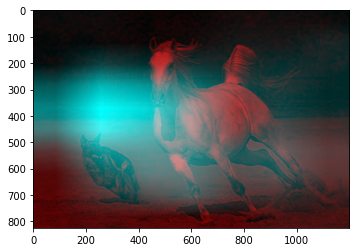

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


354 Arabian camel, dromedary, Camelus dromedarius


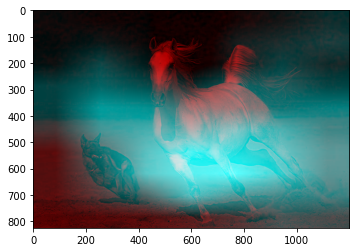

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


339 sorrel


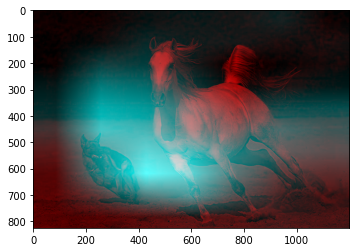

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


172 whippet


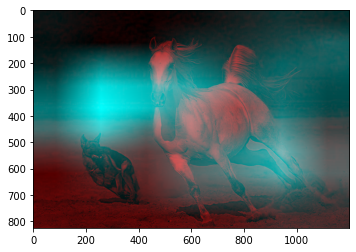

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


160 Afghan hound, Afghan


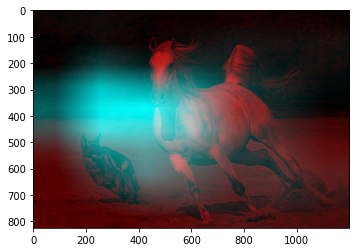

In [42]:
import seaborn as sns

original = cv2.imread("./doge-and-horsy.jpg")
# plt.imshow(original)
original.shape

for i in idx:
    print(i, clsidx[str(i)])
    plt.figure()
    cam = y[..., i]
    cam = np.transpose(cam)
    cam /= (cam.max() + 1e-5)
    cam = cv2.resize(cam, (1200, 825))
    t = original.astype(np.float32) / 255.0
    t[..., 1] = cam
    t[..., 2] = cam
    plt.imshow(t)
    
    plt.show()

# Модификация сети

В torch.nn есть слой Identity, можно заменить ненужные операции на него.

Но что делать с нужными? Сделайте так, чтобы веса FC-слоя можно было применить прямо в модельке и получить CAM.


In [45]:
to_train = []
for k, v in net.named_parameters():
    print(k, v.shape)
    if 'bias' in k:
        to_train.append(v)


    
opt = Adam([])

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

_Hint: FC можно представить сверткой 1x1._
